# TP Mines–Paris 2026 — Reinforcement Learning and Preference Learning for LLMs

In this practical session, you will implement **preference learning** and **policy-gradient style** objectives that are commonly used in RLHF-style training for LLMs (DPO/IPO/CoPG, etc.).   To keep the compute cost tiny, we work with a **3-armed bandit**: a “policy” is simply a probability distribution over 3 actions (arms).

## What you will have to do ?
- Build a **synthetic preference dataset** from two behavior distributions.
- Represent and train a **softmax policy** with learnable logits.
- Implement and compare **pairwise preference losses** (Policy Gradient, DPO, IPO, CoPG).
- Monitor learning using **regularized expected reward** and **regret**.

> Each exercise below must be answered by writing **one piece of code in the cell directly under the question** (typically a function).


## Setting: KL-regularized 3-armed bandit

We consider 3 actions (arms) with deterministic rewards:

- Arm 0: reward 2.5  
- Arm 1: reward 2.0  
- Arm 2: reward 1.0

We also use a **reference policy** $\pi_\mathrm{ref}$ (uniform over arms) and a temperature/regularization parameter $\beta$.  Most losses in this TP combine **reward maximization** with **regularization toward $\pi_\mathrm{ref}$** (as in KL-regularized RL).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ---------------------------
# 1) Setup: Offline Bandit with a fixed Dataset
# ---------------------------

N_ARMS = 3

# We have 3 arms with rewards R = (2.5, 2.0, 1.0)
R_vals = torch.tensor([2.5, 2.0, 1.0], dtype=torch.float)
R_vals2 = torch.tensor([1.0, 2.5, 2.0], dtype=torch.float)

# Reference distribution pi_ref = 1/3 each
pi_ref = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float)

# Temperature (regularization) parameter
beta = 0.5

# Data distributions mu1, mu2
mu1 = np.array([0.1, 0.2, 0.7])
mu2 = np.array([0.05, 0.05, 0.9])




## Question 1 — Build a preference dataset

Write code that generates a dataset of *pairs of actions* \((y, y')\).

- First sample $y \sim \mu_1$ and $y' \sim \mu_2$ independently.
- Return a `torch.LongTensor` of shape `(n_samples, 2)` where each row is `(y, y')`.

**Expected output:** a tensor `dataset` containing `n_samples` comparisons. Create a function to reorder the dataset such as `y>y'` in `(y, y')`. Return a `torch.LongTensor` of shape `(len(data), 2)`.

This creates a clean *preferred vs rejected* dataset suitable for pairwise losses.


In [ ]:
def sample_dataset(n_samples=10_000, mu1=mu1, mu2=mu2):
    """
    Generate a dataset of (y, y') arm pairs.
    Each y is drawn from mu1, each y' from mu2.
    Returns a torch LongTensor of shape [n_samples, 2].
    """
    ys   = np.random.choice(3, size=n_samples, p=mu1)
    ys_p = np.random.choice(3, size=n_samples, p=mu2)

    pairs=torch.from_numpy(np.stack([ys, ys_p], axis=1))

    return pairs

dataset = sample_dataset(n_samples=10_000)


def reordeted_data(data):

    reordered = []
    for (a,b) in data:
        if R_vals[a] >= R_vals[b]:
              reordered.append([a,b])
        else:
              reordered.append([b,a])
    return torch.tensor(reordered, dtype=torch.long)

order_dataset=reordeted_data(dataset)


## Question 2 — Policy parameterization

Implement a **softmax policy** $\pi_\theta$ over the 3 arms.

1. `make_policy()` must return a learnable tensor of **logits** (a `torch.nn.Parameter`) of shape `(3,)`.
2. `get_pi_and_logpi(logits)` must return:
   - `pi = softmax(logits)`  
   - `log_pi = log_softmax(logits)`

These helpers will be reused by all objectives.


In [ ]:

# We'll train in minibatches of size 512
batch_size = 512

# A simple "DataLoader-like" generator:
def get_batches(dataset, batch_size):
    idx = torch.randperm(len(dataset))
    for i in range(0, len(dataset), batch_size):
        yield dataset[idx[i:i+batch_size]]

# ---------------------------
# 2) Policy Parameterization
# ---------------------------
# We represent the policy pi_\theta over the 3 arms by raw logits:
#    pi(y) = softmax(logits)[y]

def make_policy():
    return nn.Parameter(torch.zeros(3, dtype=torch.float))

def get_pi_and_logpi(logits):
    pi = torch.softmax(logits, dim=0)
    log_pi = torch.log_softmax(logits, dim=0)
    return pi, log_pi




## Question 3 — Evaluation: expected reward and regret

Implement:
- `compute_expected_reward(pi)`  
- `compute_regret(pi)`

Use the **KL-regularized objective**:
$$
J(\pi) = \sum_a \pi(a) R(a) - \beta \; \mathrm{KL}(\pi\,\|\,\pi_{ref})
$$

Then define regret as:
$$
\mathrm{Regret}(\pi) = J(\pi^*) - J(\pi)
$$
where $\pi^*$ is the optimal regularized policy.

You should also compute `optimal_pi` in the code cell.


In [ ]:

R_vals = torch.tensor([2.5, 2.0, 1.0], dtype=torch.float) # Rewards
beta = 0.5  # Regularization parameter
pi_ref = torch.tensor([1/3, 1/3, 1/3], dtype=torch.float)

# Compute softmax policy
optimal_pi =  pi_ref  *   torch.exp(R_vals / beta) / torch.sum(  pi_ref  *   torch.exp(R_vals / beta)    )
print(optimal_pi)

def compute_expected_reward(pi):
    """
    The unregularized expected reward under policy pi,
    for the 3-arm bandit with R_vals = (2.5, 2.0, 1.0).
    """

    return None

def compute_regret(pi):
    """
    Regret = (best arm reward) - (policy's expected reward).
    The best arm is arm 0 with reward 2.5.
    """

    return None

tensor([0.7054, 0.2595, 0.0351])



## Question 4 — Implement the loss functions

Implement the following functions **in PyTorch**, operating on a minibatch of pairs `(y, y')`:

- `pg_loss(logits, batch, **kwargs)`  : Classical policy gradient method, writte also a method with version with variance reduction using mean baseline over the batch.
- `dpo_loss(logits, batch, **kwargs)`  DPO paper https://arxiv.org/abs/2305.18290
- `ipo_loss(logits, batch, **kwargs)`   IPO paper : https://arxiv.org/abs/2310.12036
- `copg_loss(logits, batch, **kwargs)`  CoPG paper https://arxiv.org/abs/2406.19185



**Requirements**
- `batch` is a tensor of shape `(B, 2)` where `batch[:,0]` is the preferred action and `batch[:,1]` is the rejected action.
- Use the global variables `R_vals`, `pi_ref`, and `beta`.
- Add numerical stability terms like `+ 1e-10` when taking logs.

> Tip: keep the functions **vectorized** (no Python loops over the minibatch).

In [ ]:
# ---------------------------
# 3) Corrected Pairwise Losses
# ---------------------------

def ipo_loss(logits, batch,**kwargs):
    """
    IPO loss
    """

    return loss

def copg_loss(logits, batch,**kwargs):
    """
    A simplified CoPG-like loss from the references:
    """

    return loss

def pg_loss(logits, batch, **kwargs):
    
    return  loss

def dpo_loss(logits, batch,**kwargs):
    """
    DPO loss
    """
    
    return loss



## Question 4 — Training loop + regret tracking

Implement `train_policy(loss_fn, dataset, lr, epochs, batch_size, **kwargs)`.

The function must:
1. Create logits with `make_policy()`.
2. Optimize them with Adam for `epochs` iterations.
3. Iterate over minibatches (use `get_batches`).
4. Every 10 epochs, compute and store the **regret** of the current policy.
5. Return the final policy `pi_final` and the list `all_regret`.

**Goal:** after training, the learned policy should as much as possible concentrate probability on the best arm.



In [ ]:

# ---------------------------
# 4) Training Routine
# ---------------------------

def train_policy(loss_fn, dataset, lr=1e-3, epochs=200, batch_size=512,**kwargs):
    return None

In [ ]:
# ---------------------------
# 5) Run each method
# ---------------------------

print("=== Training with DPO Loss (pairwise) ===")
pi_dpo, dpo_regret = train_policy(dpo_loss, dataset, lr=2e-4, epochs=500, batch_size=batch_size)
print("Final DPO policy:", pi_dpo.numpy(), "\n")

print("=== Training with IPO Loss (pairwise) ===")
pi_ipo , ipo_regret  = train_policy(ipo_loss, dataset, lr=2e-4, epochs=500, batch_size=batch_size)
print("Final IPO policy:", pi_ipo.numpy(), "\n")

print("=== Training with CoPG Loss (pairwise) ===")
pi_copg, copg_regret  = train_policy(copg_loss, dataset, lr=2e-4, epochs=500, batch_size=batch_size)
print("Final CopG policy:", pi_copg.numpy(), "\n")


=== Training with DPO Loss (pairwise) ===
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
Epoch  10 | avg loss = 0.6869
1.932826578617096
1.8543979711830616


/tmp/ipython-input-4095932865.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print((pi * R_vals    ).sum().item() -  (pi * (np.log(pi + eps) - np.log(pi_ref + eps))).sum().item()  )
/tmp/ipython-input-4095932865.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return   (pi * R_vals).sum() -  beta  *(pi * (np.log(pi + eps) - np.log(pi_ref + eps))).sum()


Epoch  20 | avg loss = 0.6805
1.932826578617096
1.8733461014926434
Epoch  30 | avg loss = 0.6744
1.932826578617096
1.8902951665222645
Epoch  40 | avg loss = 0.6683
1.932826578617096
1.9053449966013432
Epoch  50 | avg loss = 0.6625
1.932826578617096
1.9186224341392517
Epoch  60 | avg loss = 0.6567
1.932826578617096
1.9302443712949753
Epoch  70 | avg loss = 0.6515
1.932826578617096
1.9403371959924698
Epoch  80 | avg loss = 0.6460
1.932826578617096
1.949001207947731
Epoch  90 | avg loss = 0.6407
1.932826578617096
1.9563380479812622
Epoch 100 | avg loss = 0.6354
1.932826578617096
1.9624457359313965
Epoch 110 | avg loss = 0.6307
1.932826578617096
1.9674472659826279
Epoch 120 | avg loss = 0.6261
1.932826578617096
1.9714311882853508
Epoch 130 | avg loss = 0.6212
1.932826578617096
1.9744856730103493
Epoch 140 | avg loss = 0.6169
1.932826578617096
1.9767192155122757
Epoch 150 | avg loss = 0.6123
1.932826578617096
1.9781858399510384
Epoch 160 | avg loss = 0.6077
1.932826578617096
1.9789915531873

In [ ]:
print("=== Training with PG Loss (pairwise) ===")
pi_pg, pg_regret = train_policy(pg_loss, dataset, lr=2e-4, epochs=500, batch_size=batch_size, baseline=False)
print("Final DPO policy:", pi_pg.numpy(), "\n")

print("=== Training with PG Loss with variance reduction (pairwise) ===")
pi_pg_b , pg_b_regret  = train_policy(pg_loss, dataset, lr=2e-4, epochs=500, batch_size=batch_size, baseline=True)
print("Final IPO policy:", pi_pg_b.numpy(), "\n")



=== Training with DPO Loss (pairwise) ===
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
Epoch  10 | avg loss = 2.6128
1.932826578617096
1.8105771485716105


/tmp/ipython-input-4095932865.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print((pi * R_vals    ).sum().item() -  (pi * (np.log(pi + eps) - np.log(pi_ref + eps))).sum().item()  )
/tmp/ipython-input-4095932865.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return   (pi * R_vals).sum() -  beta  *(pi * (np.log(pi + eps) - np.log(pi_ref + eps))).sum()


Epoch  20 | avg loss = 2.5276
1.932826578617096
1.787034947425127
Epoch  30 | avg loss = 2.4563
1.932826578617096
1.7629335187375546
Epoch  40 | avg loss = 2.3919
1.932826578617096
1.7384633347392082
Epoch  50 | avg loss = 2.3428
1.932826578617096
1.7138418182730675
Epoch  60 | avg loss = 2.2934
1.932826578617096
1.6893054768443108
Epoch  70 | avg loss = 2.2575
1.932826578617096
1.665015809237957
Epoch  80 | avg loss = 2.2209
1.932826578617096
1.6411550864577293
Epoch  90 | avg loss = 2.1962
1.932826578617096
1.6179320961236954
Epoch 100 | avg loss = 2.1754
1.932826578617096
1.5955120027065277
Epoch 110 | avg loss = 2.1571
1.932826578617096
1.574109435081482
Epoch 120 | avg loss = 2.1424
1.932826578617096
1.553749367594719
Epoch 130 | avg loss = 2.1274
1.932826578617096
1.5346333533525467
Epoch 140 | avg loss = 2.1191
1.932826578617096
1.516871154308319
Epoch 150 | avg loss = 2.1120
1.932826578617096
1.500493660569191
Epoch 160 | avg loss = 2.1009
1.932826578617096
1.485556811094284
Ep

## Exercise 6 — Plot and compare methods

Implement a function `plot_multiple_regrets(regrets_multiple, labels=None)` that plots multiple regret curves on the same figure.

- `regrets_multiple` is a list of lists (one list per method).
- Each inner list contains regret values (scalars or tensors) over time.
- Add axis labels and a legend.

Then plot the regret for DPO / IPO / CoPG on the same graph.


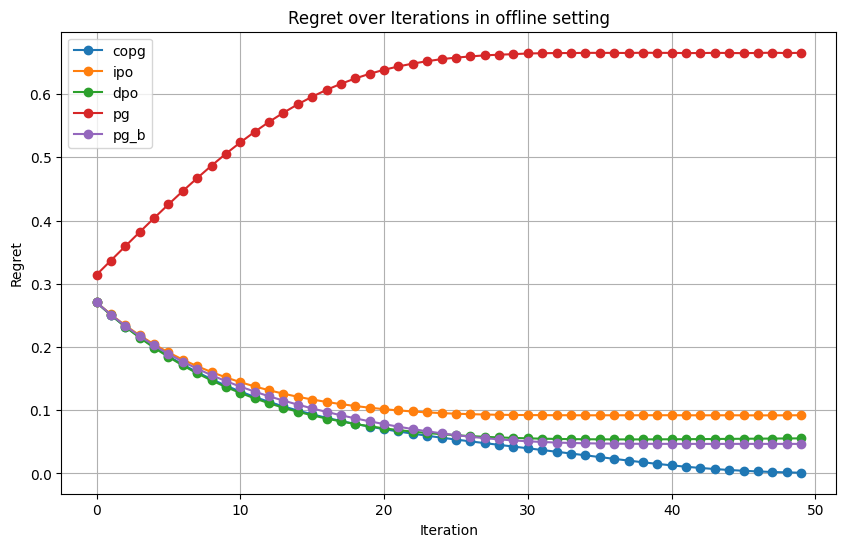

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_multiple_regrets(regrets_multiple, labels=None):
    """
    Plots multiple COPG regret values over iterations.

    Args:
        copg_regrets (list of list of torch.Tensor): A list containing multiple series of regret values.
            Each series is a list of PyTorch tensors representing the regret at each iteration.
        labels (list of str, optional): A list of labels for each series. If None, default labels are generated.
    """
    return None

# Example usage:
# Create two example series of COPG regret values

# Plot both series with custom labels
plot_multiple_regrets([ copg_regret, ipo_regret,dpo_regret , pg_regret,pg_b_regret], labels=["copg", "ipo","dpo",  "pg",'pg_b'  ])




## Exercise 7 — Plot, compare methods and critisize your results

- Comments your results about convergence, speed etc... Are the algorithn supposed to converge in the offline setting ? Do you think that the way you simulate/create the fix dataset in the first question influence or not convergence ?

- Play a bit with hyperparameters and comments about robustness of algorithms.

- Comments bias and variance of algorithms running multiple seeds ?


